# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from libs.dataset import FER2013_dataset
from libs.helper_func import mean_face_generation

# Load FER2013 dataset

In [2]:
dataset = FER2013_dataset()

# Mean Face Generation

In [3]:
label_dict = dataset.label_dict
print("Emotion ID")
print(label_dict)

Emotion ID
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [4]:
def get_mean_face(config, show=True, info=True):
    emotion = label_dict[config['emotion_id']]
    dataset = FER2013_dataset()
    images = dataset.get_data(config)
    if info:
        print("{}:".format(emotion), images.shape,  end='')
    mean_face = mean_face_generation(images)

    if show:
        plt.imshow(mean_face, cmap="gray")
        plt.title("Mean Face: {}".format(emotion))
        plt.show()
    return mean_face

## Angry

Angry: (3995, 48, 48)

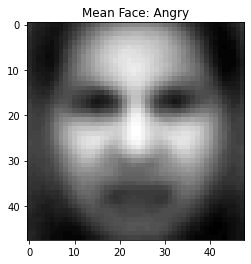

In [5]:
config = {
    'dataset_type': 'train',
    'emotion_id':0
}
_ = get_mean_face(config)

## Disgust

Disgust: (436, 48, 48)

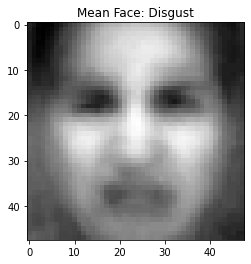

In [6]:
config = {
    'dataset_type': 'train',
    'emotion_id':1
}
_ = get_mean_face(config)

## Fear

Fear: (4097, 48, 48)

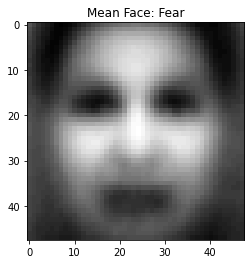

In [7]:
config = {
    'dataset_type': 'train',
    'emotion_id':2
}
_ = get_mean_face(config)

## Happy

Happy: (7215, 48, 48)

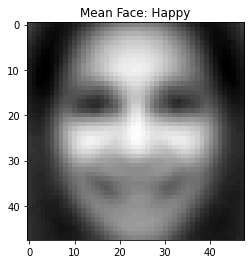

In [8]:
config = {
    'dataset_type': 'train',
    'emotion_id':3
}
_ = get_mean_face(config)

## Sad

Sad: (4830, 48, 48)

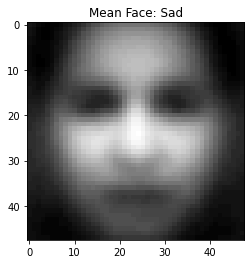

In [9]:
config = {
    'dataset_type': 'train',
    'emotion_id':4
}
_ = get_mean_face(config)

## Surprise

Surprise: (3171, 48, 48)

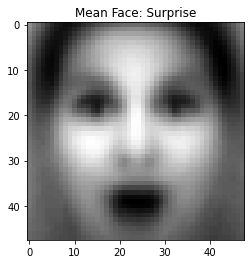

In [10]:
config = {
    'dataset_type': 'train',
    'emotion_id':5
}
_ = get_mean_face(config)

## Neutral

Neutral: (4965, 48, 48)

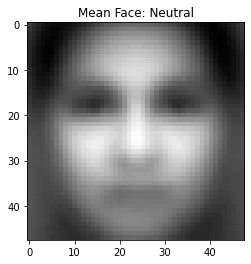

In [11]:
config = {
    'dataset_type': 'train',
    'emotion_id':6
}
_ = get_mean_face(config)

# Principal Component Analysis 

## Suprise

### Load data

In [12]:
config = {
    'dataset_type': 'train',
    'emotion_id':5
}
mean_face = get_mean_face(config, show=False)
images = dataset.get_data(config)

Surprise: (3171, 48, 48)

### Calculating SVD

In [13]:
n_images = images/255.0
n_mean_face = mean_face/255.0

data = n_images - n_mean_face
data = data.reshape((-1, 48*48)).T # data.shape = MxN where M is 48*48 (image size) nad N is number of samples

U, sigma, Vh = np.linalg.svd(data)


### Eigenvalues and Ratio of Variance

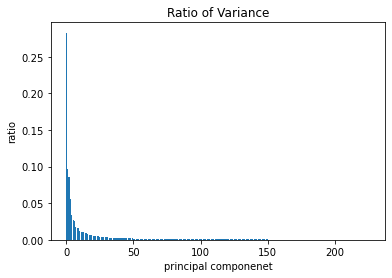

Recover 95.0% requires 227 principal components


In [14]:
def desire_pc(eig, score=0.95):
    csum = 0
    tv = 0
    for i in range(eig.shape[0]):
        csum = csum + eig[i]
        tv = csum / np.sum(eig)
        if tv > score:
            return i

score = 0.95
eig = sigma**2/(sigma.shape[0]-1)
n_component = desire_pc(eig, score)
ratio_of_variance = eig/np.sum(eig)
plt.bar(np.arange(n_component), ratio_of_variance[:n_component])
plt.xlabel('principal componenet')
plt.ylabel('ratio')
plt.title('Ratio of Variance')
plt.show()

print('Recover {}% requires {} principal components'.format(score*100, n_component))

### Eigenfaces

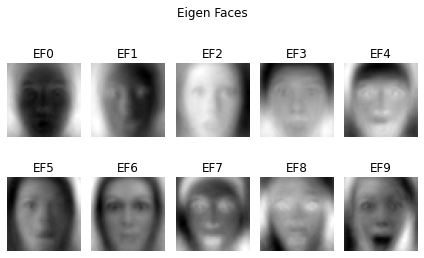

In [15]:
eigenfaces = U[:, :n_component]
fig, axes = plt.subplots(2,5)
for i in range(10):
    row = i//5
    column = i%5
    axes[row, column].imshow(eigenfaces[:, i].reshape((48,48)), cmap="gray")
    axes[row, column].set(title='EF{}'.format(i))
    axes[row, column].axis('off')

fig.suptitle('Eigen Faces')
fig.tight_layout()
fig.show()


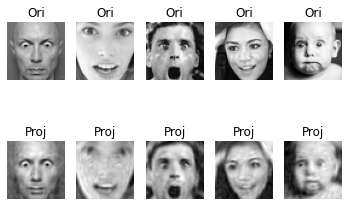

In [16]:
fig, axes = plt.subplots(2,5)
for i in range(5):
    axes[0, i].imshow(n_images[i], cmap="gray") 
    Cm = np.dot(eigenfaces, np.dot(eigenfaces.T, data))
    axes[0, i].set(title="Ori")
    axes[0, i].axis('off')
    axes[1, i].imshow(n_mean_face+Cm[:, i].reshape((48,48)), cmap="gray")
    axes[1, i].set(title="Proj")
    axes[1, i].axis('off')
plt.show()

## Calculate Eigenfaces for all emotions

### Get minimum number of principal components

In [18]:
def get_min_components():
    
    min_component = 0
    
    svd = []
    mean_faces = []
    for emotion_id in label_dict.keys():
        config = {
        'dataset_type': 'train',
        'emotion_id':emotion_id
        }

        mean_face = get_mean_face(config, show=False)
        images = dataset.get_data(config)

        n_images = images/255.0
        n_mean_face = mean_face/255.0

        data = n_images - n_mean_face
        data = data.reshape((-1, 48*48)).T # data.shape = MxN where M is 48*48 (image size) nad N is number of samples

        U, sigma, Vh = np.linalg.svd(data)
        score = 0.95
        eig = sigma**2/(sigma.shape[0]-1)
        n_component = desire_pc(eig, score)
        print(", Components Needed:{}".format(n_component))
        
        svd.append([U, sigma, Vh])
        mean_faces.append(n_mean_face)
        if n_component > min_component:
            min_component = n_component
    mean_faces = np.array(mean_faces)
    return svd, min_component, mean_faces

svd, min_component, mean_faces = get_min_components()
print("Minimum principal components need: {}".format(min_component))

Angry: (3995, 48, 48), Components Needed:239
Disgust: (436, 48, 48), Components Needed:101
Fear: (4097, 48, 48), Components Needed:244
Happy: (7215, 48, 48), Components Needed:241
Sad: (4830, 48, 48), Components Needed:220
Surprise: (3171, 48, 48), Components Needed:227
Neutral: (4965, 48, 48), Components Needed:212
Minimum principal components need: 244


### Get Eigenfaces

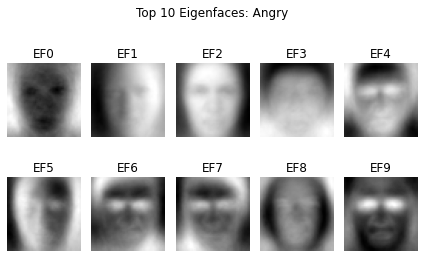

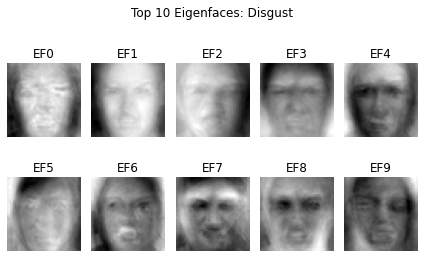

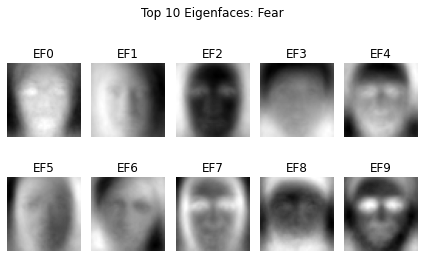

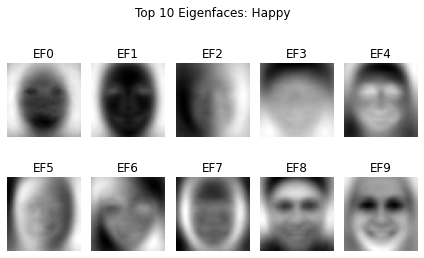

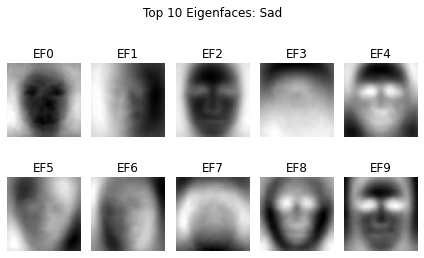

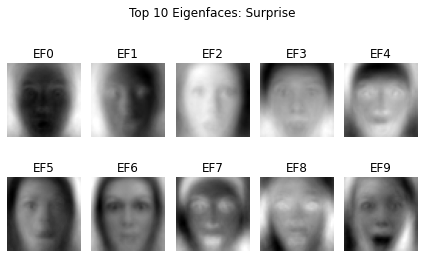

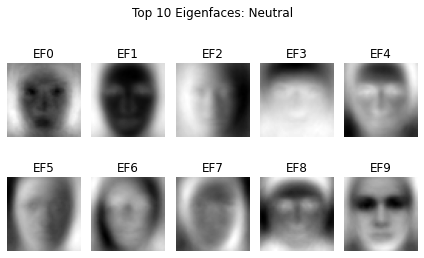

In [19]:
def get_eigenfaces(show=True):
    all_eigenfaces = []
    for idx, [U, sigma, Vh] in enumerate(svd):
        eigenfaces = U[:, :min_component]
        if show:
            fig, axes = plt.subplots(2,5)
            for i in range(10):
                row = i//5
                column = i%5
                axes[row, column].imshow(eigenfaces[:, i].reshape((48,48)), cmap="gray")
                axes[row, column].set(title='EF{}'.format(i))
                axes[row, column].axis('off')

            fig.suptitle('Top 10 Eigenfaces: {}'.format(label_dict[idx]))
            fig.tight_layout()
            fig.show()
        
        all_eigenfaces.append(eigenfaces.T.reshape(-1, 48, 48))
    
    all_eigenfaces = np.array(all_eigenfaces)
    return all_eigenfaces

all_eigenfaces = get_eigenfaces()

### Save Mean faces/Eigenfaces 

In [20]:
save = True
out_path = "./dataset/fer2013/meanfaces_eigenfaces.pkl"
print("Mean Faces: ", mean_faces.shape)
print("All Eigenfaces: ", all_eigenfaces.shape)

if save:
    mf_ef_data = {}
    for emotion_id in range(mean_faces.shape[0]):
        my_dict = {
            'mean_face':mean_faces[emotion_id],
            'eigenfaces':all_eigenfaces[emotion_id]
        }
        mf_ef_data[emotion_id] = my_dict
        
    with open(out_path, 'wb') as pickle_file:
        pkl.dump(mf_ef_data, pickle_file)
    
    print('Done Saving.')
    

Mean Faces:  (7, 48, 48)
All Eigenfaces:  (7, 244, 48, 48)
Done Saving.
